# Fine-grained Arabic Named Entity Recognition

# Bi-LSTM Model

# Load Notebook Environment
Load the pretrained kernel and environment without having to rerun all cells.

In [1]:
import dill
dill.load_session('July4_G.db')

2024-08-25 20:33:04.159620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import Libraries

In [1]:
import ast

import numpy as np

import codecs

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import InputLayer, Embedding, LSTM, Dense, Activation

from keras.optimizers import Adam

from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

2024-08-25 15:28:41.050420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read/Processes Training Data

In [2]:
sentences = []
labels = []

curr_sentence = []
curr_labels = []
final_lines = []
final = ""
with open("/Users/ziadhamwi/Desktop/Thesis/Current/FINAL IOB CONVERSION__/Updated Files/Files_HERE/Dataset/UpdatedDataset/TrainingG_Data.txt", "r") as file:
    for line in file:
        if line != "\n":
            label, word = line.split()[:2]
            
            final_lines.append(f"{label} {word}\n")
            
            curr_sentence.append(word)
            curr_labels.append(label)
        else:
            final_lines.append("\n")
            sentences.append(curr_sentence)
            labels.append(curr_labels)
            curr_sentence = []
            curr_labels = []
            
final = "".join(final_lines)

print("DONE!")


DONE!


In [3]:
print(len(final))

9768817


In [4]:
new_format = []
sentence = []

output2023 = ["["]
lines = final.split('\n')
drop = len(final.split('\n'))

for i in range(drop):
    curr_line = lines[i]
    if len(curr_line) != 0:
        parts = curr_line.split()
        subentity = parts[0]
        word = parts[1]

        if word != ".":
            output2023.append(f"('{word}', '{subentity}')")
            if i != drop-1:  
                output2023.append(", ")
        else:
            output2023.append("('.', 'OUTSIDE')]\n[")
            
if output2023[-1] == "[":
    output2023.pop()
else:
    if output2023[-1] == ", ":
        output2023.pop()

output2023.append("]")

output2023 = "".join(output2023)


print("Done!")


Done!


In [5]:
training_sentences = []
for line in output2023[:-3].split("\n"):
    training_sentences.append(line+"\n")
    
print(len(training_sentences))


27200


# Read/Processes Testing Data

In [6]:
sentences = []
labels = []

curr_sentence = []
curr_labels = []
final_lines = []
final = ""
with open("/Users/ziadhamwi/Desktop/Thesis/Current/FINAL IOB CONVERSION__/Updated Files/Files_HERE/Dataset/TestingData.txt", "r") as file:
    for line in file:
        if line != "\n":
            label, word = line.split()[:2]
            
            final_lines.append(f"{label} {word}\n")
            
            curr_sentence.append(word)
            curr_labels.append(label)
        else:
            final_lines.append("\n")
            sentences.append(curr_sentence)
            labels.append(curr_labels)
            curr_sentence = []
            curr_labels = []
            
final = "".join(final_lines)

sentencesTest = sentences
trueLabels = labels


print("DONE!")


DONE!


In [7]:
print(len(final))

306023


In [8]:
new_format = []
sentence = []

output2023 = ["["]
lines = final.split('\n')
drop = len(final.split('\n'))

for i in range(drop):
    curr_line = lines[i]
    if len(curr_line) != 0:
        parts = curr_line.split()
        subentity = parts[0]
        word = parts[1]

        if word != ".":
            output2023.append(f"('{word}', '{subentity}')")
            if i != drop-1:
                output2023.append(", ")
        else:
            output2023.append("('.', 'OUTSIDE')]\n[")
            
if output2023[-1] == "[":
    output2023.pop()
else:
    if output2023[-1] == ", ":
        output2023.pop()

output2023.append("]")

output2023 = "".join(output2023)


print("Done!")


Done!


In [9]:
testing_sentences = []
for line in output2023[:-3].split("\n"):
    testing_sentences.append(line+"\n")
    
print(len(testing_sentences))


856


# Preview data

In [10]:
# Display a few rows of the dataset
num_rows = 5  # Number of rows to display
print("\n\nTraining Set")
for i in range(num_rows):
    print(training_sentences[i])

print("\n\nTesting Set")
for i in range(num_rows):
    print(testing_sentences[i])



Training Set
[('إنجلترا', 'B-Country'), ('أو', 'OUTSIDE'), ('إنكلترا', 'B-Country'), ('أو', 'OUTSIDE'), ('إنكلترة', 'B-Country'), ('بالإنجليزية', 'B-Language'), ('إنگلاند', 'OUTSIDE'), ('هي', 'OUTSIDE'), ('أكبر', 'OUTSIDE'), ('دولة', 'OUTSIDE'), ('في', 'OUTSIDE'), ('المملكة', 'B-Country'), ('المتحدة', 'I-Country'), ('وتشترك', 'OUTSIDE'), ('في', 'OUTSIDE'), ('الحدود', 'OUTSIDE'), ('البرية', 'OUTSIDE'), ('مع', 'OUTSIDE'), ('اسكتلندا', 'B-Country'), ('في', 'OUTSIDE'), ('الشمال', 'OUTSIDE'), ('وويلز', 'OUTSIDE'), ('في', 'OUTSIDE'), ('الغرب', 'OUTSIDE'), ('والبحر', 'B-Body_Of_Water'), ('الأيرلندي', 'I-Body_Of_Water'), ('في', 'OUTSIDE'), ('الشمال', 'OUTSIDE'), ('الغربي', 'OUTSIDE'), ('وبحر', 'B-Body_Of_Water'), ('الكلت', 'I-Body_Of_Water'), ('في', 'OUTSIDE'), ('الجنوب', 'OUTSIDE'), ('الغربي', 'OUTSIDE'), ('وبحر', 'B-Body_Of_Water'), ('الشمال', 'I-Body_Of_Water'), ('في', 'OUTSIDE'), ('الشرق', 'OUTSIDE'), ('وتفصلها', 'OUTSIDE'), ('القناة', 'OUTSIDE'), ('الإنجليزية', 'B-Language'), ('عن', 'OU

# NLP Data Preprocessing Functions for Neural Network Training

In [11]:
def get_words(sentences):
    return set(word for sentence in sentences for word in sentence)

def get_tags(sentence_tags):
    return set(tag for tags in sentence_tags for tag in tags)

def get_train_sentences_x(sentences, word2index):
    return [[word2index[word] for word in sentence] for sentence in sentences]

def get_test_sentences_x(sentences, word2index):
    return [[word2index.get(word, word2index['-OOV-']) for word in sentence] for sentence in sentences]

def get_train_tags_y(tags, tag2index):
    return [[tag2index[tag] for tag in tag_sequence] for tag_sequence in tags]

def get_test_tags_y(tags, tag2index):
    return [[tag2index[tag] for tag in tag_sequence] for tag_sequence in tags]

# Converting Logits to Tokens in Natural Language Processing

In [13]:
# Function to convert logits to tokens
def logits_to_tokens(predictions, index_to_tag):
    return [index_to_tag[np.argmax(prediction)] for prediction in predictions]

# Extracting Sentences and Tags from Tagged Sentences in Natural Language Processing

In [14]:
# Extract sentences and tags from tagged sentences -> Training Sentences/Tags
sentences_training, training_sentence_tags = [], []
for tagged_sentence in training_sentences:
    try:
        sentence, tags = zip(*ast.literal_eval(tagged_sentence.strip()))
        sentences_training.append(list(sentence))  # Convert to list to handle Arabic characters
        training_sentence_tags.append(list(tags))
    except SyntaxError:
        print(f"SyntaxError -Training- in line: {tagged_sentence.strip()}")
        

# Extract sentences and tags from tagged sentences -> Testing Sentences/Tags
sentences_testing, testing_sentence_tags = [], []
for tagged_sentence in testing_sentences:
    try:
        sentence, tags = zip(*ast.literal_eval(tagged_sentence.strip()))
        sentences_testing.append(list(sentence))  # Convert to list to handle Arabic characters
        testing_sentence_tags.append(list(tags))
    except SyntaxError:
        print(f"SyntaxError -Testing- in line: {tagged_sentence.strip()}")
        
        
train_sentences = sentences_training
train_tags = training_sentence_tags

test_sentences = sentences_testing
test_tags = testing_sentence_tags

# Obtaining Unique Words and Tags from NLP Data

In [15]:
# Get unique words and tags
words = get_words(train_sentences)
tags = get_tags(train_tags)

# Creating Word-to-Index and Tag-to-Index Dictionaries for NLP Data

In [16]:
# Create word-to-index and tag-to-index dictionaries
word2index = {w: i + 2 for i, w in enumerate(words)}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1

tag2index = {t: i + 1 for i, t in enumerate(tags)}
tag2index['-PAD-'] = 0


# Converting Sentences and Tags to Index Sequences for NLP Model Training

In [17]:
# Convert sentences and tags to index sequences
train_sentences_x = get_train_sentences_x(train_sentences, word2index)
test_sentences_x = get_test_sentences_x(test_sentences, word2index)

train_tags_y = get_train_tags_y(train_tags, tag2index)
test_tags_y = get_test_tags_y(test_tags, tag2index)

# Padding Sequences for Uniform Length in NLP Model Training


In [18]:
# Pad sequences to a common length
MAX_LENGTH = max(len(max(train_sentences_x, key=len)), len(max(test_sentences_x, key=len)))

train_sentences_x = pad_sequences(train_sentences_x, maxlen=MAX_LENGTH, padding='post')
test_sentences_x = pad_sequences(test_sentences_x, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

# Building and Compiling a Bidirectional LSTM Model for Sequence Labeling

In [19]:
from keras.layers import Bidirectional

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH,)))
model.add(Embedding(len(word2index), 128))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

# Training


In [20]:
# Train the model
history = model.fit(train_sentences_x, to_categorical(train_tags_y, len(tag2index)), batch_size=32, epochs=10, verbose=1)

Epoch 1/10
850/850 [==============================] - 306s 357ms/step - loss: 0.1361 - accuracy: 0.9838
Epoch 2/10
850/850 [==============================] - 314s 370ms/step - loss: 0.0440 - accuracy: 0.9923
Epoch 3/10
850/850 [==============================] - 360s 424ms/step - loss: 0.0285 - accuracy: 0.9944
Epoch 4/10
850/850 [==============================] - 357s 420ms/step - loss: 0.0195 - accuracy: 0.9955
Epoch 5/10
850/850 [==============================] - 291s 342ms/step - loss: 0.0143 - accuracy: 0.9962
Epoch 6/10
850/850 [==============================] - 273s 321ms/step - loss: 0.0108 - accuracy: 0.9968
Epoch 7/10
850/850 [==============================] - 273s 321ms/step - loss: 0.0089 - accuracy: 0.9971
Epoch 8/10
850/850 [==============================] - 272s 320ms/step - loss: 0.0076 - accuracy: 0.9974
Epoch 9/10
850/850 [==============================] - 272s 321ms/step - loss: 0.0067 - accuracy: 0.9976
Epoch 10/10
850/850 [==============================] - 271s 319m

# Model Anatomy


In [21]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 289, 128)          7299712   
                                                                 
 bidirectional (Bidirection  (None, 289, 256)          263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 289, 213)          54741     
                                                                 
 activation (Activation)     (None, 289, 213)          0         
                                                                 
Total params: 7617621 (29.06 MB)
Trainable params: 7617621 (29.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Save Model


In [22]:
model.save("BiLSTM_G_10_Epoch.h5")

/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Dump Notebook Environment
Dump current kernel and notebook environment to the file below so you can quickly load it next time you open the notebook.

In [2]:
import dill
# dill.dump_session('Aug25_G_10_Epoch.db')
dill.load_session("Aug25_G_10_Epoch.db")

2024-08-25 20:42:09.452160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(test_sentences_x)

predicted_labels = np.argmax(predictions, axis=2)

true_labels_flat = test_tags_y.flatten()
predicted_labels_flat = predicted_labels.flatten()

non_pad_elements = true_labels_flat != 0

conf_matrix = confusion_matrix(true_labels_flat[non_pad_elements], predicted_labels_flat[non_pad_elements])

print("Confusion Matrix:")
print(conf_matrix)


27/27 [==============================] - 3s 86ms/step
Confusion Matrix:
[[ 0  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  4]]


In [4]:
from sklearn.metrics import classification_report
from tabulate import tabulate

non_pad_elements = true_labels_flat != 0

report = classification_report(true_labels_flat[non_pad_elements], 
                               predicted_labels_flat[non_pad_elements], 
                               labels=np.unique(predicted_labels_flat[non_pad_elements]))

print("Classification Report:")
# print(report)


array_output = report.split()

for i in range(4, len(array_output)-20, 5):
    id = array_output[i]
    
    desired_value = int(id)
    desired_key = None

    for key, value in tag2index.items():
        if value == desired_value:
            desired_key = key
            break
    array_output[i] = desired_key
    
# print(array_output)
array_output = array_output[9:]

# print(len(array_output))
for i in range(len(array_output) - 1, -1, -1):
    if array_output[i] == "avg":
        array_output[i-1] += "_avg"
        del array_output[i]
# print(array_output)


table = [array_output[i:i+5] for i in range(0, len(array_output), 5)]

print(tabulate(table[0:], headers=['Precision', 'Recall', 'F1-score', 'Support'], tablefmt='pretty'))



Classification Report:
+---------------------------+-----------+--------+----------+---------+
|                           | Precision | Recall | F1-score | Support |
+---------------------------+-----------+--------+----------+---------+
|        B-Religion         |   0.92    |  0.77  |   0.84   |   31    |
|          B-Date           |   0.67    |  0.70  |   0.68   |   239   |
|           B-God           |   1.00    |  1.00  |   1.00   |    6    |
|        I-Currency         |   0.67    |  0.71  |   0.69   |   14    |
|         I-Soldier         |   0.00    |  0.00  |   0.00   |    1    |
|        B-Body_Part        |   1.00    |  0.06  |   0.11   |   54    |
|         B-County          |   0.00    |  0.00  |   0.00   |    3    |
|         B-Monarch         |   0.00    |  0.00  |   0.00   |    7    |
|     I-Sports_Facility     |   1.00    |  1.00  |   1.00   |    2    |
|        B-Language         |   0.76    |  0.86  |   0.80   |   69    |
|         B-Artist          |   0.85    |

/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Testing the Model

This code turns the model into a tag-wielding champion! Equipped with a custom function, it takes any sentence and predicts the appropriate tag for each word, like adding punctuation marks to complete a thought. Watch as it analyzes a sample sentence and unveils its predicted tags, revealing the model's real-world potential to understand and structure language on the fly!

In [5]:
# Function to predict tags for a given sentence
def predict_tags(sentence, model, word2index, index2tag):

    sentence_x = [word2index.get(word, word2index['-OOV-']) for word in sentence]

    sentence_x = pad_sequences([sentence_x], maxlen=MAX_LENGTH, padding='post')

    predictions = model.predict(sentence_x)

    predicted_tags = logits_to_tokens(predictions[0], index2tag)

    return predicted_tags

test_sentence = ['كيرلا', 'هي', 'ولاية', 'هندية', 'تقع', 'على', 'ساحل', 'مليبار', 'الهندي', '،', 'أُنشئت', 'في', '1', 'نوفمبر', '1956', 'بعد', 'إقرار', 'قانون', 'إعادة', 'تنظيم', 'الولايات', '،', 'حيث', 'جمعت', 'بين', 'المناطق', 'الناطقة', 'باللغة', 'المالايالامية', 'من', 'مناطق', 'كوشين', 'ومليبار', 'وجنوب', 'كانارا', 'وترافانكور', '،', 'وتبلغ', 'مساحتها', '38,863', 'كيلومتر', 'مربع', '(15,005', 'ميل2)', 'وهي', 'الولاية', 'الهندية', 'الحادية', 'والعشرون', 'من', 'حيث', 'المساحة', '،', 'تحدها', 'ولاية', 'كارناتاكا', 'من', 'الشمال', 'والشمال', 'الشرقي', '،', 'وتاميل', 'نادو', 'من', 'الشرق', 'والجنوب', '،', 'وبحر', 'لكديف', 'من', 'الغرب', '.']



index2tag = {i: t for t, i in tag2index.items()}

predicted_tags = predict_tags(test_sentence, model, word2index, index2tag)

print("Original Sentence:", test_sentence)
print("Predicted Tags:", predicted_tags)

1/1 [==============================] - 0s 45ms/step
Original Sentence: ['كيرلا', 'هي', 'ولاية', 'هندية', 'تقع', 'على', 'ساحل', 'مليبار', 'الهندي', '،', 'أُنشئت', 'في', '1', 'نوفمبر', '1956', 'بعد', 'إقرار', 'قانون', 'إعادة', 'تنظيم', 'الولايات', '،', 'حيث', 'جمعت', 'بين', 'المناطق', 'الناطقة', 'باللغة', 'المالايالامية', 'من', 'مناطق', 'كوشين', 'ومليبار', 'وجنوب', 'كانارا', 'وترافانكور', '،', 'وتبلغ', 'مساحتها', '38,863', 'كيلومتر', 'مربع', '(15,005', 'ميل2)', 'وهي', 'الولاية', 'الهندية', 'الحادية', 'والعشرون', 'من', 'حيث', 'المساحة', '،', 'تحدها', 'ولاية', 'كارناتاكا', 'من', 'الشمال', 'والشمال', 'الشرقي', '،', 'وتاميل', 'نادو', 'من', 'الشرق', 'والجنوب', '،', 'وبحر', 'لكديف', 'من', 'الغرب', '.']
Predicted Tags: ['B-County', 'OUTSIDE', 'OUTSIDE', 'B-Nationality', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'B-Nationality', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'B-Date', 'I-Date', 'I-Date', 'OUTSIDE', 'OUTSIDE', 'B-Law', 'I-Law', 'I-Law', 'I-Law', 'I-Law', 'OUTSIDE', 'OUTSIDE', 'OUTSIDE', 'OUT

In [6]:
labelsPredictedArray = []
# for i in range(len(sentencesTest)):
i = 0
while i < len(sentencesTest):
    if i != 813:
        test_sentence = sentencesTest[i]
        predicted_labels = predict_tags(test_sentence, model, word2index, index2tag)

        # Filter out '-PAD-' tokens from the predicted labels
        filtered_labels = [label for label in predicted_labels if label != '-PAD-']

        labelsPredictedArray.append(filtered_labels)

        if i % 100 == 0:
            print(round((i / len(sentencesTest)) * 100, 2), "%")

    i += 1

print("100 %")


1/1 [==============================] - 0s 41ms/step
0.0 %
1/1 [==============================] - 0s 42ms/step
11.68 %
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step
23.36 %
1/1 [==============================] - 0s 39ms/step
35.05 %
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step
46.73 %
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step
58.41 %
1/1 [==============================] - 0s 35ms/step
70.09 %
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step
81.78 %
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 34ms/step
93.46 %
1/1 [==============================] - 0s 33ms/step
100 %


In [7]:
repairTrueLabels = []

for i in range(0, len(trueLabels)):
#     print(i)
    if i != 813:
        repairTrueLabels.append(trueLabels[i])
    elif i == 813:
        print("Hell")

Hell


In [8]:
# Cell to check how many invalid true/predicted entries we have
z = 0
for i in range(0, len(repairTrueLabels)):
    if len(repairTrueLabels[i]) != len(labelsPredictedArray[i]):
        # print(len(trueLabels[i]), len(labelsPredictedArray[i]))
        z+=1
        print(i)
        # for j in range(0, len(trueLabels[i])):
            # print(trueLabels[i][j], labelsPredictedArray[i][j])
        # print(trueLabels[i], labelsPredictedArray[i])
        print()
    #     break
    # break

print("Z:", z)

Z: 0


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have your true labels and predicted labels in the following lists
y_true = [true_label for sublist in repairTrueLabels for true_label in sublist]  # Flatten your nested true labels list
y_pred = [pred_label for sublist in labelsPredictedArray for pred_label in sublist]  # Flatten your nested predicted labels list

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print a full classification report
# print(classification_report(y_true, y_pred))


Accuracy: 0.8832640725349452


/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8653792277019177
Recall: 0.8832640725349452
F1 Score: 0.855664044882129


In [10]:
# Flatten the nested lists
flat_labels_true = [item for sublist in repairTrueLabels for item in sublist]
flat_labels_pred = [item for sublist in labelsPredictedArray for item in sublist]

# Create a mapping from label words to integers
unique_labels = list(set(flat_labels_true + flat_labels_pred))
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

# Convert the labels to their corresponding integer values
y_true = [label_to_id[label] for label in flat_labels_true]
y_pred = [label_to_id[label] for label in flat_labels_pred]

# Convert unique labels to strings for classification report
unique_labels_str = [str(label) for label in unique_labels]

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=unique_labels_str)
print(report)

                           precision    recall  f1-score   support

             B-Restaurant       1.00      0.50      0.67         4
                 B-Artist       0.85      0.79      0.81        14
                   B-Food       1.00      0.07      0.13        29
               I-Province       0.00      0.00      0.00         2
               I-Computer       0.67      0.06      0.10        36
            B-Nationality       0.78      0.76      0.77       136
      I-Government_Agency       0.50      0.10      0.16        21
              B-Body_Part       1.00      0.06      0.11        54
                   B-Date       0.67      0.70      0.68       238
                I-Theater       0.00      0.00      0.00        10
                  B-Title       0.00      0.00      0.00        29
 I-Educational_Department       0.00      0.00      0.00         2
               I-Currency       0.67      0.71      0.69        14
       B-Terrorist_Attack       0.00      0.00      0.00     

/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ziadhamwi/anacond

In [11]:
y_true = [true_label for sublist in repairTrueLabels for true_label in sublist]  # Flatten your nested true labels list
y_pred = [true_label for sublist in labelsPredictedArray for true_label in sublist]  # Flatten your nested true labels list



In [12]:
def trimLabels(labels):
    
    new_labels = []

    for i in range(0, len(labels)):
        lbl = labels[i]

        if lbl != "OUTSIDE":
            if lbl[2:] == "Actor" or lbl[2:] == "Architect" or lbl[2:] == "Artist" or lbl[2:] == "Athlete" or lbl[2:] == "Author" or lbl[2:] == "Coach" or lbl[2:] == "Director" or lbl[2:] == "Doctor" or lbl[2:] == "Engineer" or lbl[2:] == "Monarch" or lbl[2:] == "Musician" or lbl[2:] == "Politician" or lbl[2:] == "Religious_Leader" or lbl[2:] == "Soldier" or lbl[2:] == "Terrorist":
                new_labels.append("Person")
            elif lbl[2:] == "City" or lbl[2:] == "Country" or lbl[2:] == "County" or lbl[2:] == "Province" or lbl[2:] == "Railway" or lbl[2:] == "Road" or lbl[2:] == "Bridge" or lbl[2:] == "Body_Of_Water" or lbl[2:] == "Island" or lbl[2:] == "Mountain" or lbl[2:] == "Glacier" or lbl[2:] == "Astral_Body" or lbl[2:] == "Cemetery" or lbl[2:] == "Park":
                new_labels.append("Location")
            elif lbl[2:] == "Airport" or lbl[2:] == "Dam" or lbl[2:] == "Hospital" or lbl[2:] == "Hotel" or lbl[2:] == "Library" or lbl[2:] == "Power_Station" or lbl[2:] == "Restaurant" or lbl[2:] == "Sports_Facility" or lbl[2:] == "Theater":
                new_labels.append("Building")
            elif lbl[2:] == "Airline" or lbl[2:] == "Company" or lbl[2:] == "Educational_Institution" or lbl[2:] == "Sports_League" or lbl[2:] == "Sports_Team" or lbl[2:] == "Terrorist_Organization" or lbl[2:] == "Government_Agency" or lbl[2:] == "Government" or lbl[2:] == "Political_Party" or lbl[2:] == "Educational_Department" or lbl[2:] == "Military" or lbl[2:] == "News_Agency":
                new_labels.append("Organization")
            elif lbl[2:] == "Engine" or lbl[2:] == "Airplane" or lbl[2:] == "Car" or lbl[2:] == "Ship" or lbl[2:] == "Spacecraft" or lbl[2:] == "Train" or lbl[2:] == "Camera" or lbl[2:] == "Mobile_Phone" or lbl[2:] == "Computer" or lbl[2:] == "Software" or lbl[2:] == "Game" or lbl[2:] == "Instrument" or lbl[2:] == "Weapon":
                new_labels.append("Product")
            elif lbl[2:] == "Film" or lbl[2:] == "Play" or lbl[2:] == "Written_Work" or lbl[2:] == "Newspaper" or lbl[2:] == "Music":
                new_labels.append("Art")
            elif lbl[2:] == "Attack" or lbl[2:] == "Election" or lbl[2:] == "Protest" or lbl[2:] == "Military_Conflict" or lbl[2:] == "Natural_Disaster" or lbl[2:] == "Sports_Event" or lbl[2:] == "Terrorist_Attack":
                new_labels.append("Event")
            elif lbl[2:] == "Time" or lbl[2:] == "Color" or lbl[2:] == "Award" or lbl[2:] == "Educational_Degree" or lbl[2:] == "Title" or lbl[2:] == "Law" or lbl[2:] == "Ethnicity" or lbl[2:] == "Language" or lbl[2:] == "Religion" or lbl[2:] == "God" or lbl[2:] == "Chemical_Thing" or lbl[2:] == "Biological_Thing" or lbl[2:] == "Medical_Treatment" or lbl[2:] == "Disease" or lbl[2:] == "Symptom" or lbl[2:] == "Drug" or lbl[2:] == "Body_Part" or lbl[2:] == "Living_Thing" or lbl[2:] == "Animal" or lbl[2:] == "Food" or lbl[2:] == "Website" or lbl[2:] == "Broadcast_Network" or lbl[2:] == "Broadcast_Program" or lbl[2:] == "Tv_Channel" or lbl[2:] == "Currency" or lbl[2:] == "Stock_Exchange" or lbl[2:] == "Algorithm" or lbl[2:] == "Programming_Language" or lbl[2:] == "Transit_System" or lbl[2:] == "Transit_Line":
                new_labels.append("Other")
            elif lbl[2:] == "Date":
                new_labels.append("Date")
            elif lbl[2:] == "Nationality":
                new_labels.append("Nationality")
        else:
            new_labels.append("OUTSIDE")
            
    return new_labels

new_actual_labels = trimLabels(y_true)
new_predicted_labels = trimLabels(y_pred)

print(len(y_true), len(new_actual_labels))
print(len(y_pred), len(new_predicted_labels))
print(classification_report(new_actual_labels, new_predicted_labels))
            
print("DONE")

21176 21176
21176 21176
              precision    recall  f1-score   support

         Art       0.96      0.22      0.36       121
    Building       1.00      0.30      0.46        70
        Date       0.81      0.85      0.83       473
       Event       0.84      0.29      0.43        91
    Location       0.89      0.72      0.80       584
 Nationality       0.78      0.76      0.77       136
     OUTSIDE       0.90      0.98      0.94     17515
Organization       0.75      0.27      0.40       295
       Other       0.77      0.32      0.45      1376
      Person       0.76      0.33      0.46       221
     Product       0.79      0.20      0.32       294

    accuracy                           0.89     21176
   macro avg       0.84      0.48      0.57     21176
weighted avg       0.88      0.89      0.87     21176

DONE


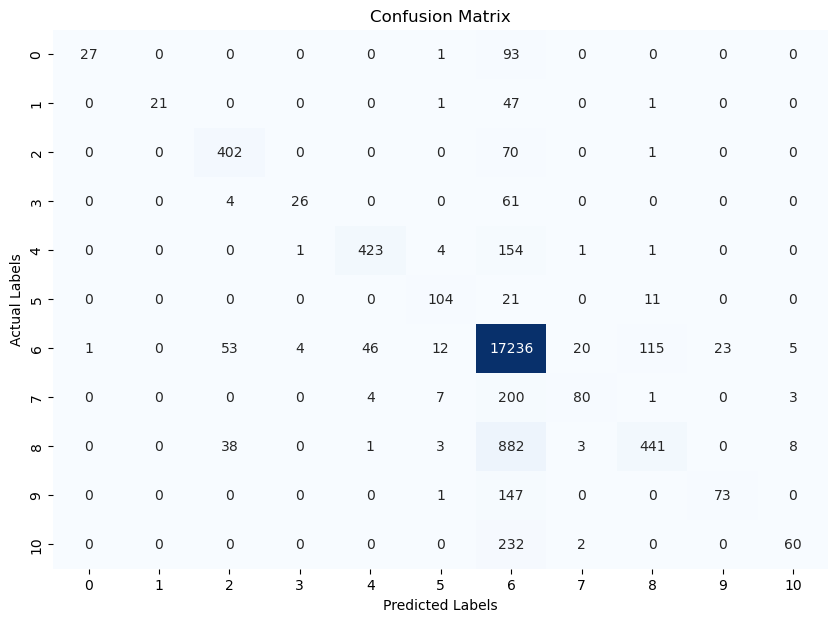

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(new_actual_labels, new_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()
